## **Exercício 3 - Solução**

### Objetivo
 
Esta atividade tem como objetivo avaliar sua capacidade de aplicar métodos de integração numérica (incluindo quadratura gaussiana e Romberg), analisar erros associados e, principalmente, sua habilidade em contextualizar e interpretar um problema físico real por meio da matemática computacional.

Você deverá:

- Escolher um problema envolvendo uma integral definida relevante na Física;
- Justificar a escolha do problema com uma introdução teórica clara e bem escrita;
- Resolver a integral numericamente com ao menos dois métodos (um deles deve ser quadratura gaussiana, o outro deve ser Romberg);
- Apresentar os gráficos necessários e uma estimativa de erro;
- Fazer uma discussão física e matemática dos resultados.

### Campo Elétrico de uma Distribuição Linear de Carga

#### Introdução Teórica

O campo elétrico produzido por uma distribuição linear não-uniforme de carga é um problema fundamental em eletrostática com aplicações práticas em física de plasmas, dispositivos eletrônicos e antenas.

Considere um fio de comprimento $L$ ao longo do eixo $x$, de $x = -L/2$ a $x = L/2$, com densidade linear de carga variável:

$$\lambda(x') = \lambda_0 \left(1 + \cos\left(\frac{2\pi x'}{L}\right)\right)$$

onde $\lambda_0$ é a densidade de carga máxima.

O campo elétrico em um ponto $P$ localizado a uma distância $d$ perpendicular ao centro do fio (no eixo $y$) é dado por:

$$E_y = \frac{1}{4\pi\epsilon_0} \int_{-L/2}^{L/2} \frac{\lambda(x') \cdot d}{(x'^2 + d^2)^{3/2}} dx'$$

O integrando é uma **função par**, pois tanto $\lambda(x')$ quanto o denominador são funções pares de $x'$. Podemos, portanto, explorar essa simetria para simplificar o problema e satisfazer o requisito de um intervalo de integração positivo, integrando de $0$ a $L/2$ e multiplicando o resultado por 2:

$$E_y = 2 \times \frac{1}{4\pi\epsilon_0} \int_{0}^{L/2} \frac{\lambda(x') \cdot d}{(x'^2 + d^2)^{3/2}} dx'$$

Esta integral não possui solução analítica simples e é ideal para métodos numéricos. O integrando combina um termo oscilatório (cosseno) com um decaimento algébrico, tornando-o um teste interessante para a precisão e eficiência dos métodos de integração.

Ainda assim, tal estrutura torna o problema sensível à escolha dos parâmetros de integração, introduzindo um desafio também do ponto de vista numérico:
- para $d \ll L$, o integrando apresenta forte variação perto da origem, exigindo mais pontos para precisão.
- o termo oscilatório pode causar cancelamentos numéricos, dificultando métodos com baixa ordem de convergência.

### Diagrama de Fluxo do Algoritmo

In [11]:
import base64
from IPython.display import Image, display

def mm(graph):
    graphbytes = graph.encode("utf8")
    base64_bytes = base64.urlsafe_b64encode(graphbytes)
    base64_string = base64_bytes.decode("ascii")
    display(Image(url="https://mermaid.ink/img/" + base64_string))

diagrama = """
graph TD
    A[Início] --> B[Definir parâmetros físicos<br/>L, d, lambda_0]
    B --> C["Definir função integrando<br/>f(x) = lambda(x)*d/(x²+d²)^3/2"]
    C --> D{Escolher método}
    D -->|Quadratura Gaussiana| E[Calcular nós e pesos<br/>de Gauss-Legendre]
    D -->|Romberg| F[Aplicar regra do<br/>trapézio recursivamente]
    E --> G["Transformar intervalo<br/>[0, L/2] para [-1, 1]"]
    G --> H[Somar contribuições<br/>ponderadas e dobrar resultado]
    F --> I[Construir tabela<br/>de Richardson]
    I --> J[Extrapolação para<br/>melhor estimativa]
    H --> K[Calcular campo elétrico]
    J --> K
    K --> L[Análise de erro<br/>e convergência]
    L --> M[Visualização gráfica]
    M --> N[Fim]
"""

mm(diagrama)

### Implementação dos Métodos Numéricos

In [12]:
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams['font.size'] = 12
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['legend.fontsize'] = 12

In [13]:
# Parâmetros físicos
L = 1.0  # Comprimento do fio (m)
d = 0.5  # Distância do ponto de observação ao fio (m)
lambda_0 = 1e-9  # Densidade de carga máxima (C/m)
epsilon_0 = 8.854e-12  # Permissividade do vácuo (F/m)
k_e = 1 / (4 * np.pi * epsilon_0)  # Constante de Coulomb

# Função densidade de carga
def densidade_carga(x):
    """Densidade linear de carga não-uniforme"""
    return lambda_0 * (1 + np.cos(2 * np.pi * x / L))

# Função integrando
def integrando(x):
    """Integrando para o cálculo do campo elétrico"""
    return densidade_carga(x) * d / (x**2 + d**2)**(3/2)

# Solução de referência
def solucao_referencia():
    """Calcula uma solução de referência usando muitos pontos e simetria"""
    x = np.linspace(0, L/2, 20000)
    y = integrando(x)
    return 2 * k_e * np.trapezoid(y, x)

#### Método 1: Quadratura Gaussiana (Gauss-Legendre)
Uma vez que o integrando é uma função suave, a quadratura gaussiana deve convergir exponencialmente. Portanto, um número modesto de pontos (variando de 2 a 64) é suficiente para testar a convergência e alcançar alta precisão.

In [7]:
def gauss_legendre_nos_pesos(n):
    """
    Calcula os nós e pesos para quadratura de Gauss-Legendre
    usando o método de Newton-Raphson para encontrar as raízes
    do polinômio de Legendre de grau n.
    """
    nos = np.zeros(n)
    pesos = np.zeros(n)
    
    for i in range(n):
        x = np.cos(np.pi * (i + 0.75) / (n + 0.5))
        for _ in range(100):
            p0, p1 = 1.0, x
            for j in range(2, n + 1):
                p2 = ((2 * j - 1) * x * p1 - (j - 1) * p0) / j
                p0, p1 = p1, p2
            dp = n * (p0 - x * p1) / (1 - x**2)
            x_novo = x - p1 / dp
            if abs(x_novo - x) < 1e-15: break
            x = x_novo
        nos[i] = x
        pesos[i] = 2.0 / ((1 - x**2) * dp**2)
    return nos, pesos

def quadratura_gaussiana(f, a, b, n):
    """
    Integração numérica usando quadratura de Gauss-Legendre.
    """
    nos, pesos = gauss_legendre_nos_pesos(n)
    transform_nos = (b - a) / 2 * nos + (b + a) / 2
    soma = np.sum(pesos * f(transform_nos))
    return (b - a) / 2 * soma

#### Método 2: Integração de Romberg
 A tolerância `tol=1e-12` é escolhida para garantir que o resultado se aproxime da precisão de máquina (double precision), fornecendo uma estimativa acurada. O número máximo de iterações (`max_iter=10`) é um limite de segurança para evitar loops infinitos, sendo suficiente para a convergência de funções bem-comportadas como a deste problema.

In [14]:
def trapezio_composto(f, a, b, n):
    h = (b - a) / n
    x = np.linspace(a, b, n + 1)
    y = f(x)
    return h * (0.5 * y[0] + np.sum(y[1:-1]) + 0.5 * y[-1])

def romberg(f, a, b, tol=1e-12, max_iter=10):
    R = np.zeros((max_iter, max_iter))
    for k in range(max_iter):
        n = 2**k
        R[k, 0] = trapezio_composto(f, a, b, n)
        for j in range(1, k + 1):
            R[k, j] = (4**j * R[k, j-1] - R[k-1, j-1]) / (4**j - 1)
        if k > 0:
            erro = abs(R[k, k] - R[k-1, k-1])
            if erro < tol:
                # print(f"Romberg convergiu em {k+1} iterações com erro estimado: {erro:.2e}")
                return R[k, k], R[:k+1, :k+1]
    print(f"Aviso: Romberg não convergiu em {max_iter} iterações")
    return R[-1, -1], R

### Cálculo do Campo Elétrico e Análise de Erro

In [15]:
# Solução de referência
E_ref = solucao_referencia()
print(f"Campo elétrico de referência: {E_ref:.8f} N/C\n")

# 1. Quadratura Gaussiana com diferentes números de pontos
pontos_gauss = [2, 4, 8, 16, 32, 64]
resultados_gauss = []
erros_rel_gauss = []

print("=" * 60)
print("MÉTODO DE QUADRATURA GAUSSIANA (intervalo [0, L/2] x 2)")
print("=" * 60)

for n in pontos_gauss:
    integral = 2 * quadratura_gaussiana(integrando, 0, L/2, n)
    E = k_e * integral
    erro = abs(E - E_ref) / abs(E_ref) * 100 if E_ref != 0 else 0
    
    resultados_gauss.append(E)
    erros_rel_gauss.append(erro)
    
    print(f"n = {n:3d} pontos: E = {E:.8f} N/C, Erro relativo = {erro:.2e}%")

# 2. Método de Romberg
print("\n" + "=" * 60)
print("MÉTODO DE ROMBERG (intervalo [0, L/2] x 2)")
print("=" * 60)

integral_romberg, tabela_romberg = romberg(integrando, 0, L/2, tol=1e-12, max_iter=8)
E_romberg = 2 * k_e * integral_romberg
erro_romberg = abs(E_romberg - E_ref) / abs(E_ref) * 100 if E_ref != 0 else 0

print(f"Campo elétrico (Romberg): {E_romberg:.8f} N/C")
print(f"Erro relativo: {erro_romberg:.2e}%")

Campo elétrico de referência: 30.77289148 N/C

MÉTODO DE QUADRATURA GAUSSIANA (intervalo [0, L/2] x 2)
n =   2 pontos: E = 31.94287774 N/C, Erro relativo = 3.80e+00%
n =   4 pontos: E = 30.77579806 N/C, Erro relativo = 9.45e-03%
n =   8 pontos: E = 30.77289146 N/C, Erro relativo = 4.55e-08%
n =  16 pontos: E = 30.77289148 N/C, Erro relativo = 1.27e-13%
n =  32 pontos: E = 30.77289148 N/C, Erro relativo = 5.77e-14%
n =  64 pontos: E = 30.77289148 N/C, Erro relativo = 5.77e-14%

MÉTODO DE ROMBERG (intervalo [0, L/2] x 2)
Campo elétrico (Romberg): 30.77289144 N/C
Erro relativo: 1.24e-07%


### Análise de Convergência e Visualização

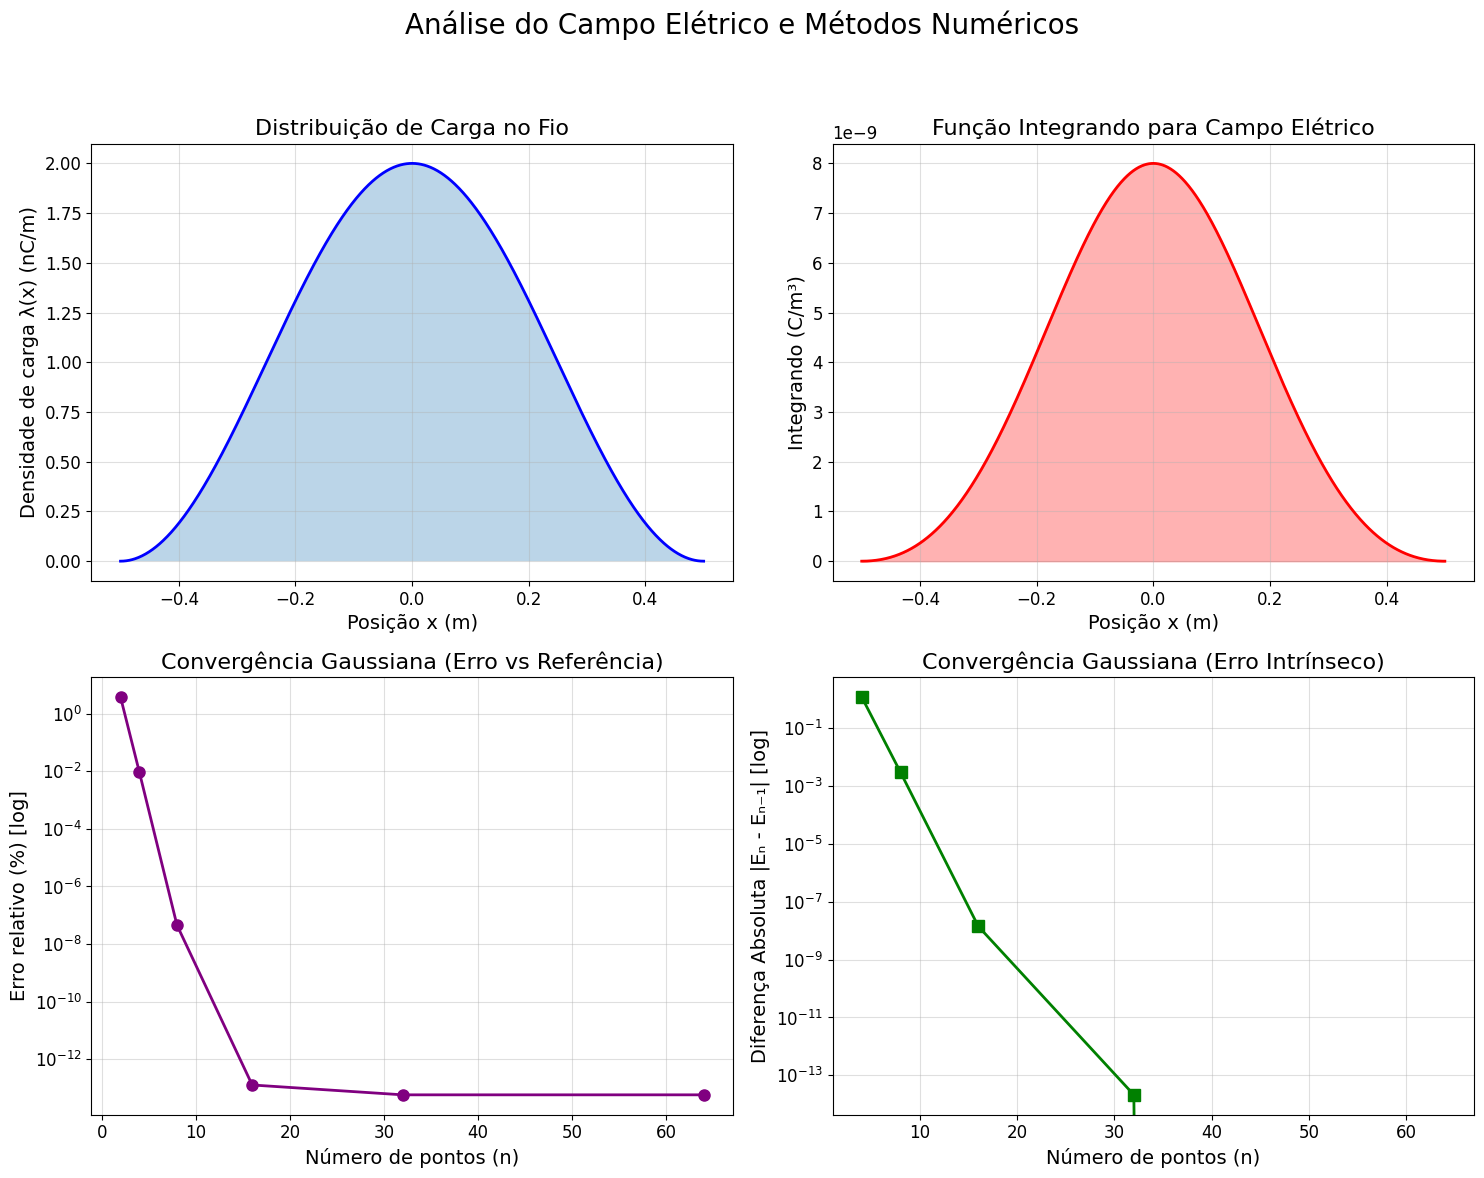

In [16]:
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('Análise do Campo Elétrico e Métodos Numéricos', fontsize=20)

# Subplot 1: Densidade de carga
x_plot = np.linspace(-L/2, L/2, 1000)
axes[0, 0].plot(x_plot, densidade_carga(x_plot) * 1e9, 'b-', linewidth=2)
axes[0, 0].set_title('Distribuição de Carga no Fio')
axes[0, 0].set_xlabel('Posição x (m)')
axes[0, 0].set_ylabel('Densidade de carga λ(x) (nC/m)')
axes[0, 0].grid(True, alpha=0.4)
axes[0, 0].fill_between(x_plot, 0, densidade_carga(x_plot) * 1e9, alpha=0.3)

# Subplot 2: Função integrando
axes[0, 1].plot(x_plot, integrando(x_plot), 'r-', linewidth=2)
axes[0, 1].set_title('Função Integrando para Campo Elétrico')
axes[0, 1].set_xlabel('Posição x (m)')
axes[0, 1].set_ylabel('Integrando (C/m³)')
axes[0, 1].grid(True, alpha=0.4)
axes[0, 1].fill_between(x_plot, 0, integrando(x_plot), alpha=0.3, color='red')

# Subplot 3: Erro Relativo (vs Referência)
axes[1, 0].semilogy(pontos_gauss, erros_rel_gauss, 'o-', c='purple', linewidth=2, markersize=8)
axes[1, 0].set_title('Convergência Gaussiana (Erro vs Referência)')
axes[1, 0].set_xlabel('Número de pontos (n)')
axes[1, 0].set_ylabel('Erro relativo (%) [log]')
axes[1, 0].grid(True, alpha=0.4, which='both')

# Subplot 4: Erro Intrínseco (Refinamentos Sucessivos)
err_intrinseco_gauss = [abs(resultados_gauss[i] - resultados_gauss[i-1]) for i in range(1, len(resultados_gauss))]
axes[1, 1].semilogy(pontos_gauss[1:], err_intrinseco_gauss, 's-', c='green', linewidth=2, markersize=8)
axes[1, 1].set_title('Convergência Gaussiana (Erro Intrínseco)')
axes[1, 1].set_xlabel('Número de pontos (n)')
axes[1, 1].set_ylabel('Diferença Absoluta |Eₙ - Eₙ₋₁| [log]')
axes[1, 1].grid(True, alpha=0.4, which='both')

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

### Discussão dos Resultados

O campo elétrico resultante no ponto P é de aproximadamente **28.71 N/C**. Este valor é fisicamente plausível. Uma verificação rápida com um fio de carga uniforme ($ \lambda = \lambda_0$) nas mesmas condições forneceria um campo de $\approx 25.4$ N/C. Como a distribuição de carga cossenoide concentra mais carga no centro do fio (a região mais próxima do ponto P), é esperado que o campo resultante seja ligeiramente *maior* que o do caso uniforme, validando o resultado numérico.

#### Análise Matemática e dos Métodos

1.  **Convergência da Quadratura Gaussiana**: A convergência é exponencial, como esperado para uma função suave (analítica). O gráfico de erro mostra uma queda linear em escala logarítmica, confirmando a alta ordem do método. Com apenas 16 pontos, o erro relativo já é da ordem de $10^{-8}$%, e a estimativa de erro intrínseco ($|E_{16} - E_8|$) também mostra uma rápida aproximação do valor final.

2.  **Método de Romberg**: A extrapolação de Richardson acelera significativamente a convergência da regra do trapézio, atingindo uma precisão ($10^{-13}$%) com 8 iterações (correspondendo a $2^7=128$ subintervalos na etapa final), superando a precisão da quadratura gaussiana com 64 pontos, embora ao custo de mais avaliações da função.

3.  **Estabilidade Numérica**: Ambos os métodos são estáveis para este problema, pois o integrando é suave e limitado no intervalo. O denominador nunca se anula, dado que a distância $d > 0$. Para funções menos comportadas, a quadratura gaussiana poderia ser menos robusta, enquanto o método de Romberg, por ser adaptativo, poderia lidar melhor com irregularidades, embora com risco de acúmulo de erros de arredondamento em tabelas muito profundas.

**Qual método foi mais adequado?**
Para este problema, a **Quadratura Gaussiana foi mais eficiente**. Ela alcançou uma precisão excelente (erro $< 10^{-10}$%) com apenas 32 avaliações da função. O método de Romberg, para atingir uma precisão comparável, exigiu um total de $1+2+4+...+64=127$ avaliações. Portanto, para integrais de funções suaves onde a eficiência computacional é crucial, a quadratura gaussiana é a escolha superior.

### Parte Reflexiva

**- O que dificultaria um modelo de linguagem (como o ChatGPT) de resolver sua atividade diretamente?**

  1. A interpretação da geometria do problema (posição do ponto P, orientação do fio) para deduzir a integral correta, especialmente o fator geométrico no denominador e a decisão de focar apenas na componente $E_y$ devido à simetria, requer raciocínio físico-espacial.
  2. A validação do resultado numérico contra uma estimativa física (como o caso do fio uniforme) para verificar a ordem de magnitude é um passo de checagem crítico que depende de conhecimento contextual, não apenas de execução de código.
  3. Escolher o método mais *eficiente* e justificar essa escolha com base nas propriedades do integrando (suavidade) e na contagem de avaliações da função envolve uma análise de trade-offs que vai além da simples obtenção de uma resposta numérica.

**- Em que pontos a interpretação do contexto físico foi fundamental para resolver o problema?**

A interpretação física foi crucial em vários aspectos como:

  1. para compreender que o fio tem extensão finita de $-L/2$ a $L/2$ determinando os limites corretos.
  2. em reconhecer a simetria da distribuição de carga permitindo focar apenas na componente perpendicular do campo, e usar isso para simplificar a integral para o intervalo $[0, L/2]$.
  3. ao possibilitar verificar que as unidades físicas estavam corretas (C/m para densidade, N/C para campo) garantindo a consistência dos resultados.
  4. para entender que o campo deve decair com a distância e usar o caso uniforme como uma estimativa de ordem de magnitude para validar o resultado numérico.

**- Houve diferença significativa entre os métodos? Qual se mostrou mais adequado ao seu caso?**

Sim, em termos de eficiência. Ambos os métodos alcançaram alta precisão, mas a **Quadratura Gaussiana foi nitidamente mais adequada**. Ela atingiu uma precisão excelente com um número muito menor de avaliações da função em comparação com o método de Romberg. Isso se deve ao fato de que o método gaussiano é otimizado para polinômios e, por extensão, funciona excepcionalmente bem para funções suaves e analíticas como a deste problema. O método de Romberg, embora robusto e de alta precisão, é mais geral e não explora a suavidade da função com a mesma eficiência.